In [1]:
import phylodata
from src.datasets.load_phylodata import load_phylodata_experiments

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set_style("darkgrid")
sns.set_theme("notebook")

In [3]:
# phylodata.prefer_preview()
phylodata.prefer_full()

In [4]:
experiments = load_phylodata_experiments()

  0%|          | 0/23 [00:00<?, ?it/s]

100%|██████████| 23/23 [00:00<00:00, 563.68it/s]


In [5]:
from tqdm import tqdm
from src.datasets.load_trees import load_trees_from_file

experiment_trees = {}

SAMPLE_SIZE = 5000

for experiment in tqdm(experiments):
    tree_file = experiment.get_file_of_type(phylodata.FileType.POSTERIOR_TREES)
    try:
        trees = load_trees_from_file(tree_file.local_path)
        if SAMPLE_SIZE < len(trees):
            trees = np.random.choice(trees, SAMPLE_SIZE, replace=False).tolist()
        experiment_trees[experiment.experiment.human_readable_id] = trees
    except:
        ...

100%|██████████| 23/23 [44:04<00:00, 114.96s/it] 


In [6]:
from src.distribution_analysis.process_tree import get_clade_split_df, get_observed_nodes
from src.utils.tree_utils import get_taxa_names

clade_dfs = []

for experiment in tqdm(experiment_trees.keys()):
    exp_trees = experiment_trees[experiment]
    taxa_names = get_taxa_names(exp_trees[0])
    observed_nodes, observed_splits = get_observed_nodes(exp_trees, taxa_names)
    clade_df = get_clade_split_df(observed_splits)
    
    clade_df["experiment_id"] = experiment
    
    clade_dfs.append(clade_df)

clade_df = pd.concat(clade_dfs)

100%|██████████| 22/22 [01:33<00:00,  4.25s/it]


In [42]:
clade_df["height"] = clade_df["tree_height"] - clade_df["height"]
clade_df["left_height"] = clade_df["height"] - clade_df["left_branch"]
clade_df["right_height"] = clade_df["height"] - clade_df["right_branch"]
clade_df["parent_height"] = clade_df["height"] + clade_df["branch_to_parent"]

### Mutual Information for Embeddings

In [7]:
from sklearn.feature_selection import mutual_info_regression
import pandas as pd
from itertools import combinations

def average_pairwise_mutual_information(clade_df, func):
    """
    Computes the average pairwise mutual information for each experiment,
    for all clade pairs, using a row-wise lambda `func` that takes a row of clade_df.
    The MI is computed across samples (trees) with matching tree_index (tree_id).
    Returns a DataFrame with experiment_id and the mean MI for that experiment.
    """
    records = []

    # Group by experiment_id
    for experiment_id, df_exp in tqdm(list(clade_df.groupby("experiment_id"))):
        # Compute the new feature for every row using the supplied lambda
        computed_values = df_exp.apply(func, axis=1)
        df_exp = df_exp.copy()
        df_exp["_computed"] = computed_values

        # Pivot the data so each clade becomes a column, and the index is tree_index
        pivot = df_exp.pivot(index="tree_index", columns="clade", values="_computed")

        clades = pivot.columns.tolist()
        pairwise_mi = []

        # Compute MI only on tree-index-aligned pairs
        for clade_a, clade_b in combinations(clades, 2):
            arr_a = pivot[clade_a].to_numpy()
            arr_b = pivot[clade_b].to_numpy()

            # Only keep rows where both values are finite
            mask = np.isfinite(arr_a) & np.isfinite(arr_b)
            arr_a_valid = arr_a[mask]
            arr_b_valid = arr_b[mask]

            # MI requires at least 2 samples
            if len(arr_a_valid) < 2:
                continue

            try:
                mi = mutual_info_regression(arr_a_valid.reshape(-1, 1), arr_b_valid, random_state=0)
                pairwise_mi.append(mi[0])
            except Exception:
                continue

        # Store mean MI per experiment_id
        if pairwise_mi:
            records.append({"experiment_id": experiment_id, "mean_clade_MI": np.mean(pairwise_mi)})
        else:
            records.append({"experiment_id": experiment_id, "mean_clade_MI": np.nan})

    return pd.DataFrame.from_records(records)

In [8]:
%%script false --no-raise-error

embeddings = {
    "Height-Ratio": lambda row: row["ratio"] if 0 < row["distance_to_root"] else row["tree_height"],
    "Shorter Branch": lambda row: row["min_branch"],
}

mutual_information_dfs = []
for embedding in embeddings:
    mutual_information_df = average_pairwise_mutual_information(
        clade_df, embeddings[embedding]
    )
    mutual_information_df["embedding"] = embedding
    mutual_information_dfs.append(mutual_information_df)

mutual_information_df = pd.concat(mutual_information_dfs)

In [9]:
%%script false --no-raise-error

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.boxplot(
    data=mutual_information_df,
    x="embedding",
    y="mean_clade_MI"
)
plt.ylabel("Mean Clade Mutual Information")
plt.xlabel("Embedding")
plt.title("Distribution of Mean Clade Mutual Information by Embedding")
plt.tight_layout()
plt.show()


## Correlations

In [46]:
CORRELATION_ANALYSES = {
    "1.1. Correlation of Sibling Branches": ["left_branch", "right_branch"],
    "1.2. Correlation of Child Parent Branch": ["branch_to_parent", "left_branch"],
    "1.3. Correlation of Branch and Tree Height": ["branch_to_parent", "tree_height"],
    "1.4. Correlation of Branch and Height": ["branch_to_parent", "height"],
    "2.1. Correlation of Sibling Ratios": ["left_ratio", "right_ratio"],
    "2.2. Correlation of Child Parent Ratio": ["parent_ratio", "ratio"],
    "2.3. Correlation of Ratio and Tree Height": ["ratio", "tree_height"],
    "2.4. Correlation of Ratio and Height": ["ratio", "height"],
    "3.1. Correlation of Sibling Heights": ["left_height", "right_height"],
    "3.2. Correlation of Child Parent Heights": ["parent_height", "height"],
    "3.3. Correlation of Height and Tree Height": ["height", "tree_height"],
}

/var/folders/gf/xs1vj06903d3n69s2lv68f6h0000gq/T/ipykernel_89544/4261833978.py:48: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


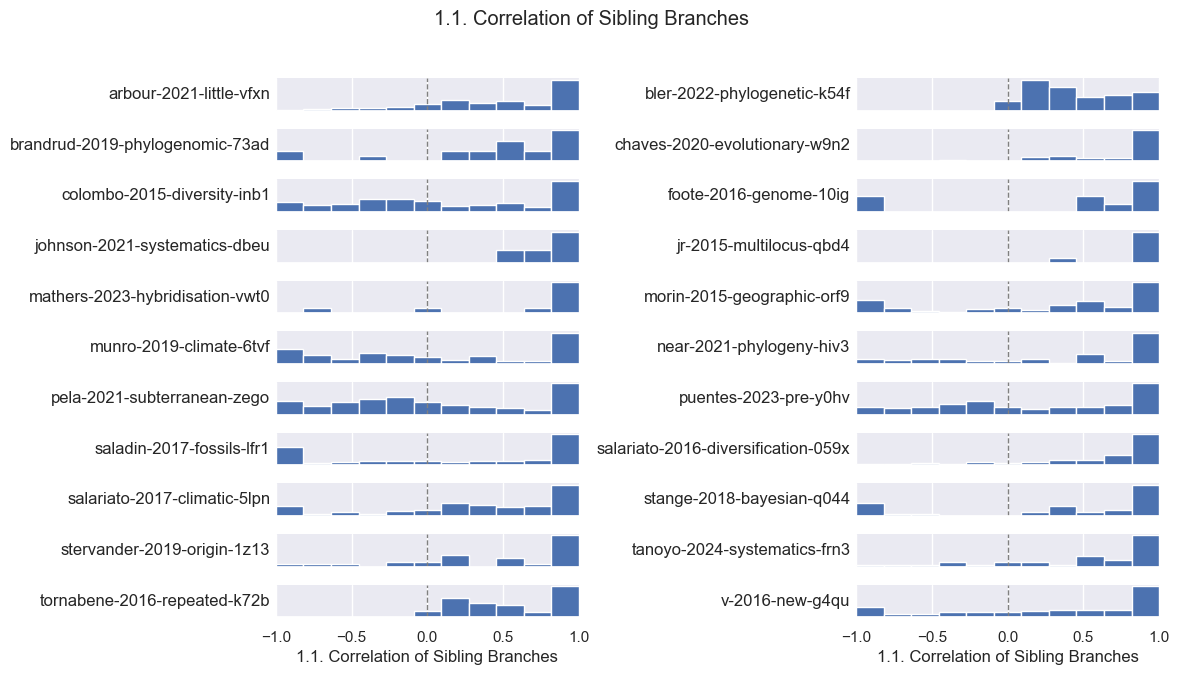

/var/folders/gf/xs1vj06903d3n69s2lv68f6h0000gq/T/ipykernel_89544/4261833978.py:48: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


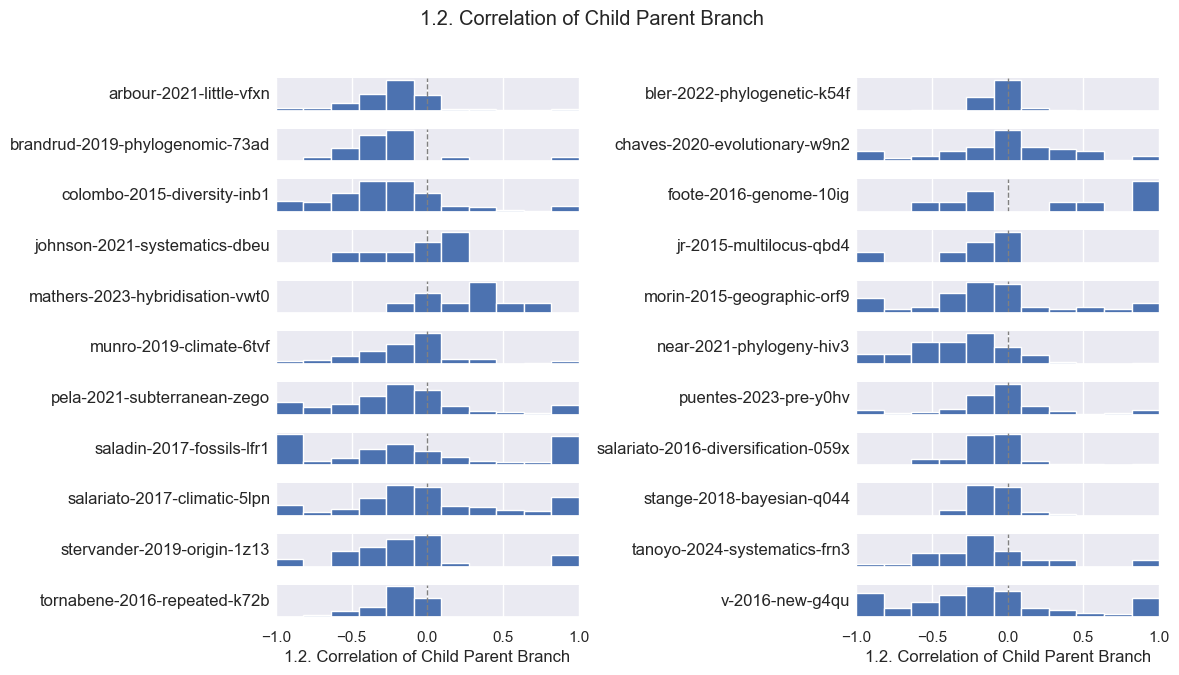

/var/folders/gf/xs1vj06903d3n69s2lv68f6h0000gq/T/ipykernel_89544/4261833978.py:48: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


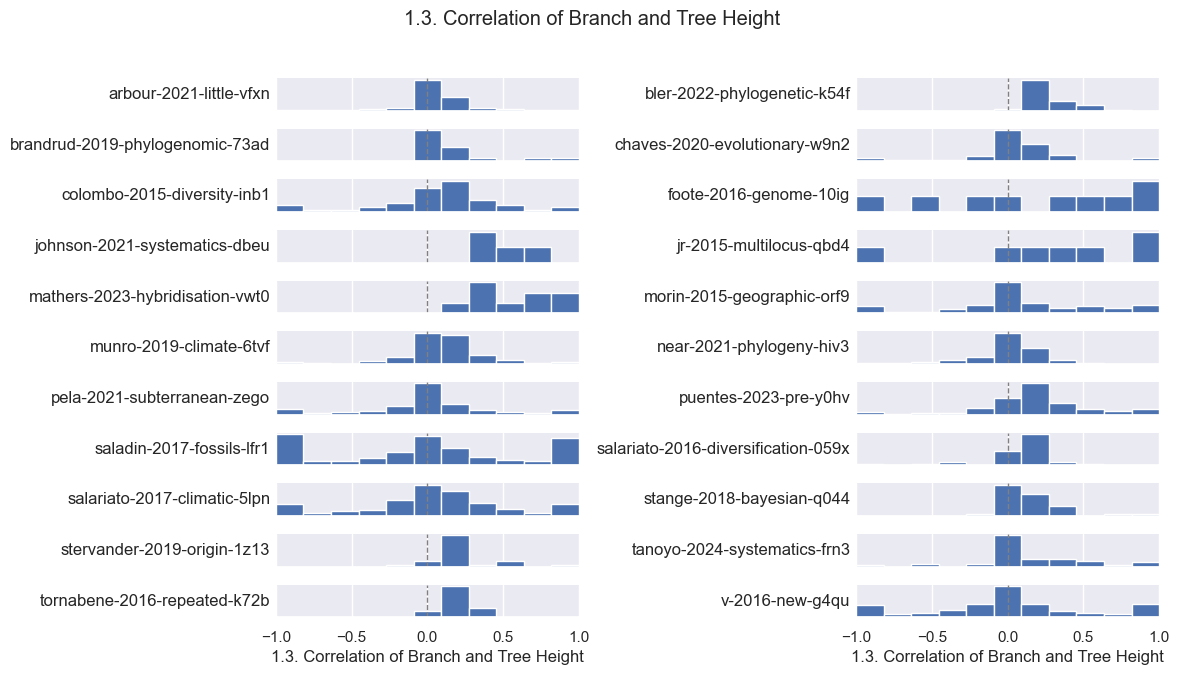

/var/folders/gf/xs1vj06903d3n69s2lv68f6h0000gq/T/ipykernel_89544/4261833978.py:48: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


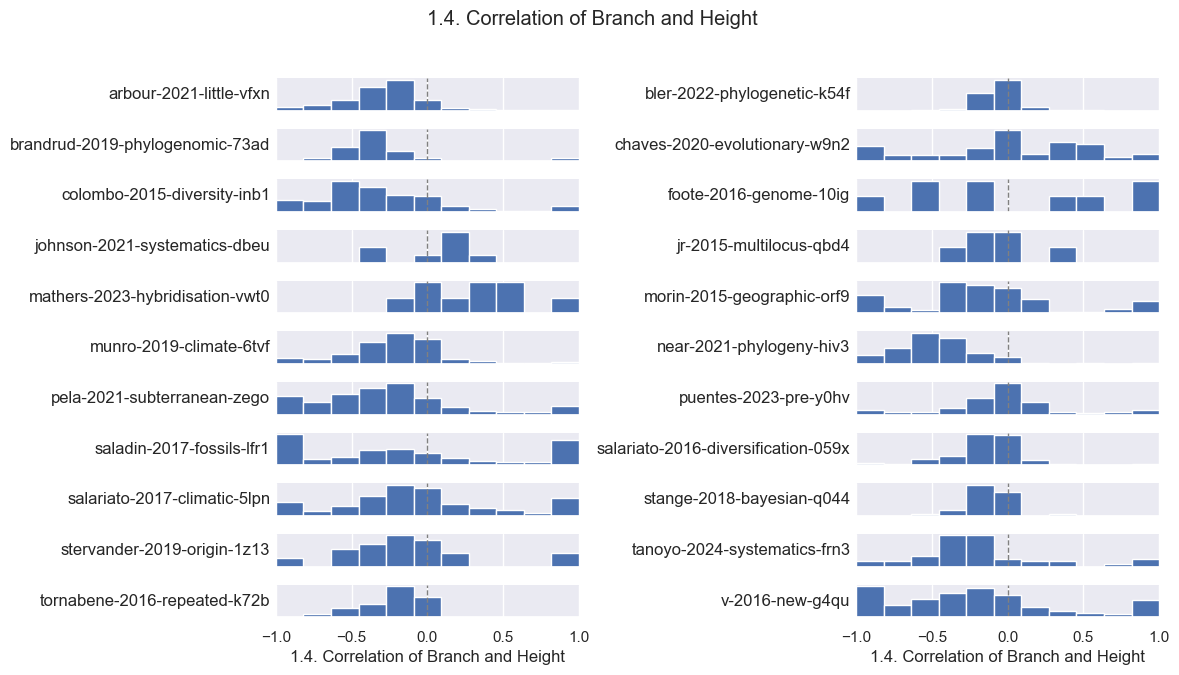

/var/folders/gf/xs1vj06903d3n69s2lv68f6h0000gq/T/ipykernel_89544/4261833978.py:48: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


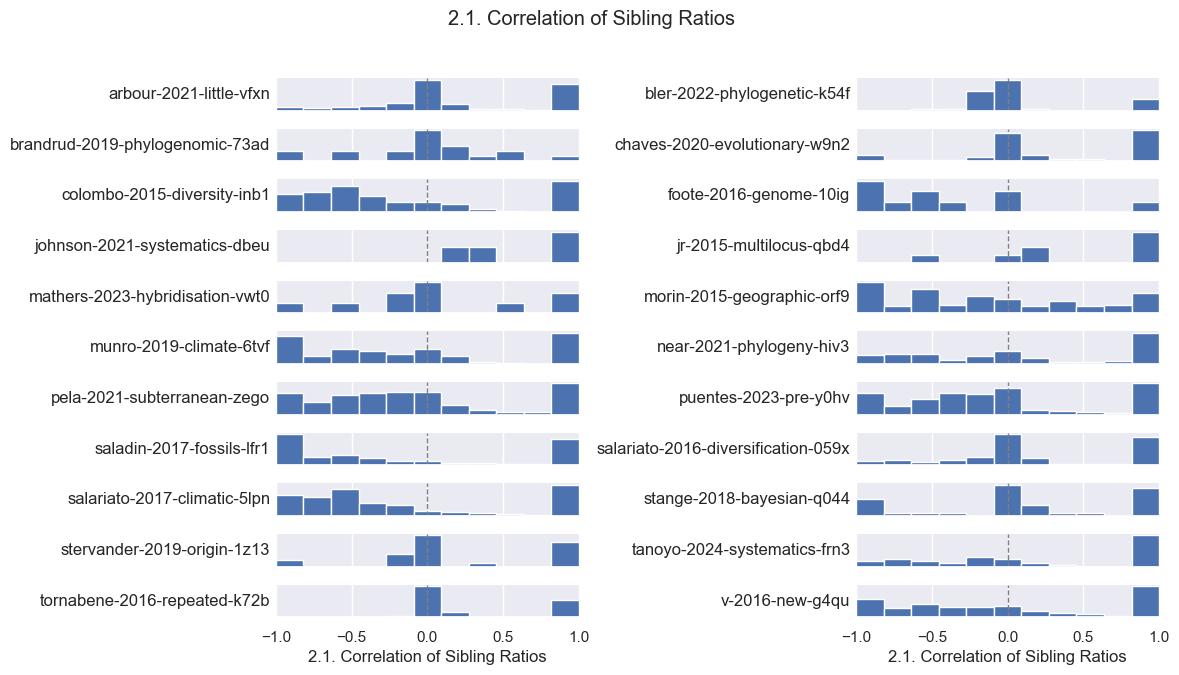

/var/folders/gf/xs1vj06903d3n69s2lv68f6h0000gq/T/ipykernel_89544/4261833978.py:48: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


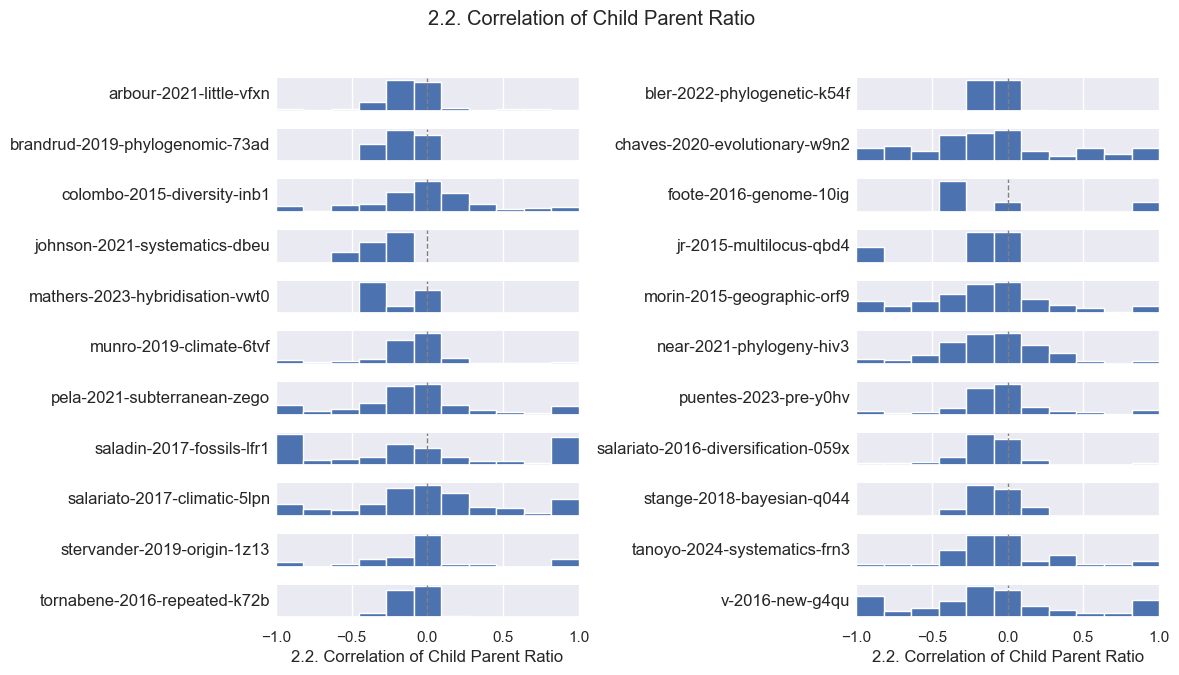

/var/folders/gf/xs1vj06903d3n69s2lv68f6h0000gq/T/ipykernel_89544/4261833978.py:48: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


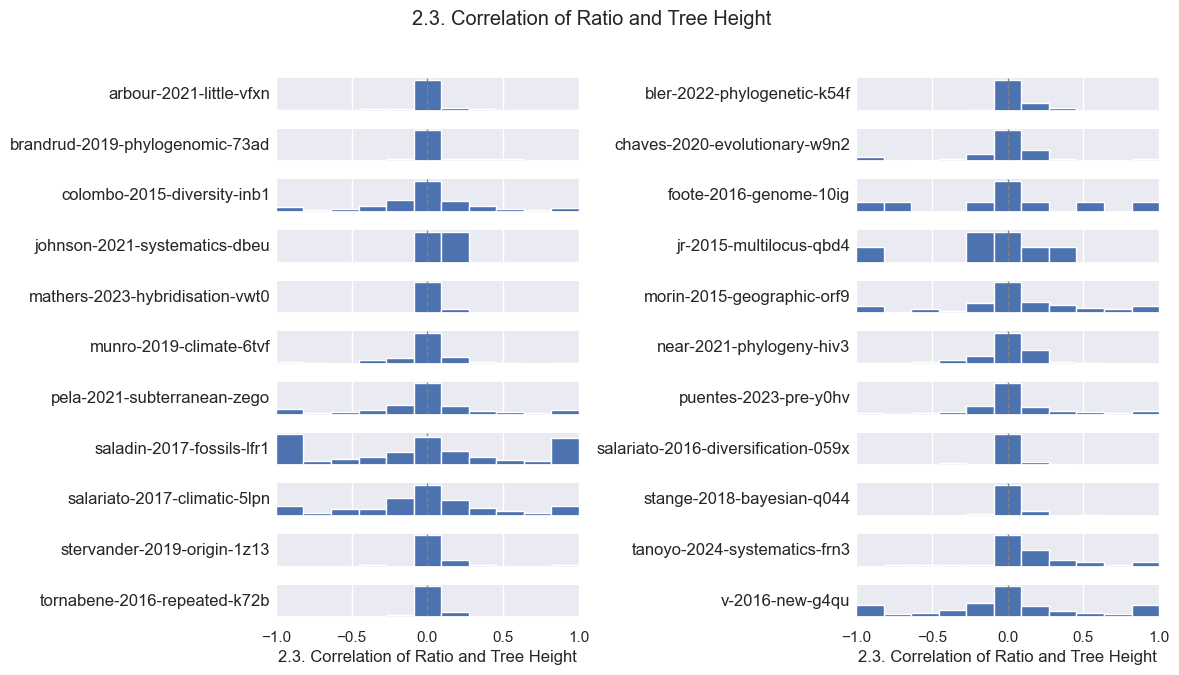

/var/folders/gf/xs1vj06903d3n69s2lv68f6h0000gq/T/ipykernel_89544/4261833978.py:48: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


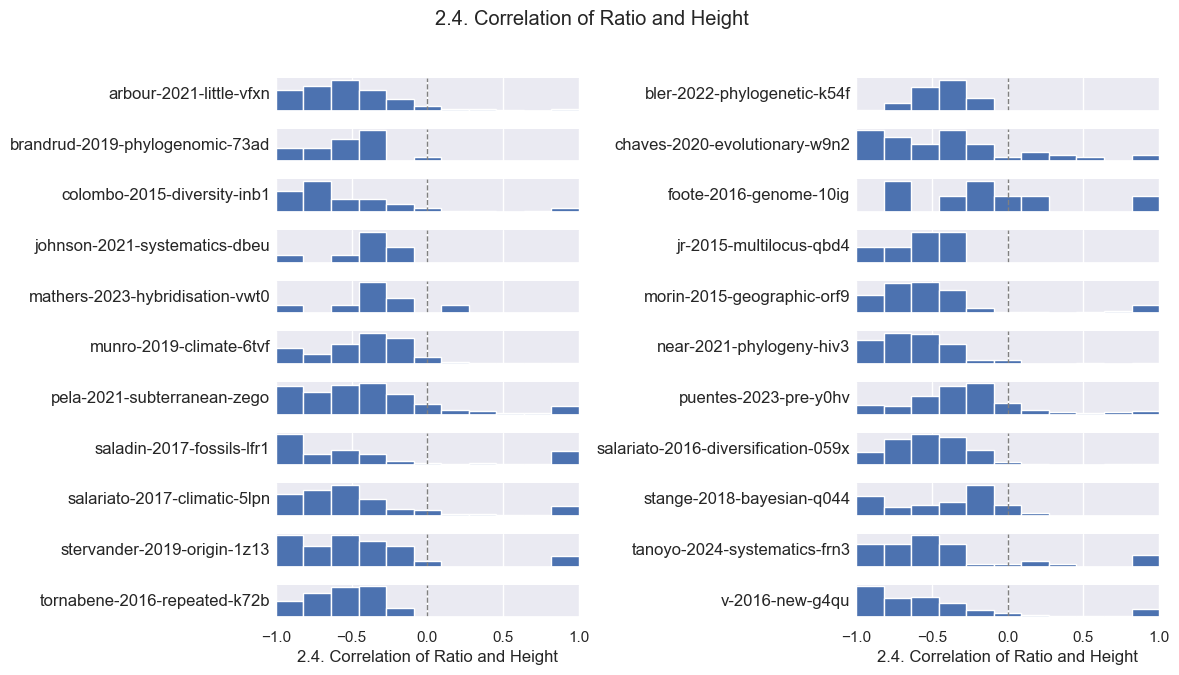

/var/folders/gf/xs1vj06903d3n69s2lv68f6h0000gq/T/ipykernel_89544/4261833978.py:48: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


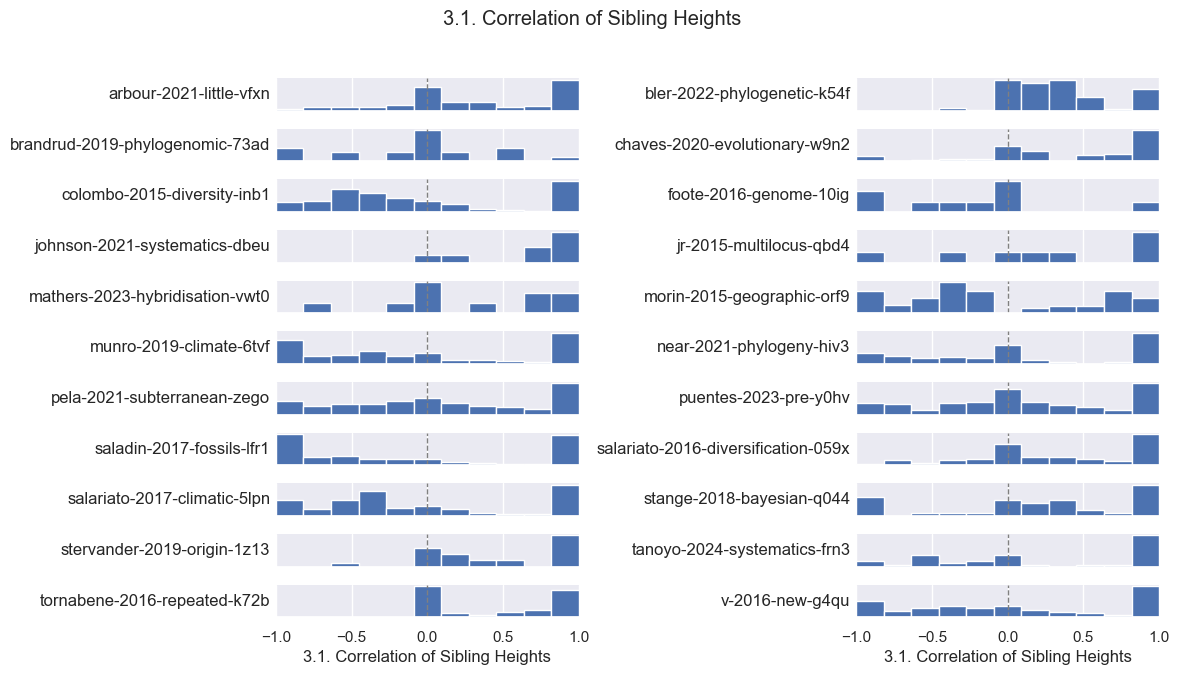

/var/folders/gf/xs1vj06903d3n69s2lv68f6h0000gq/T/ipykernel_89544/4261833978.py:48: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


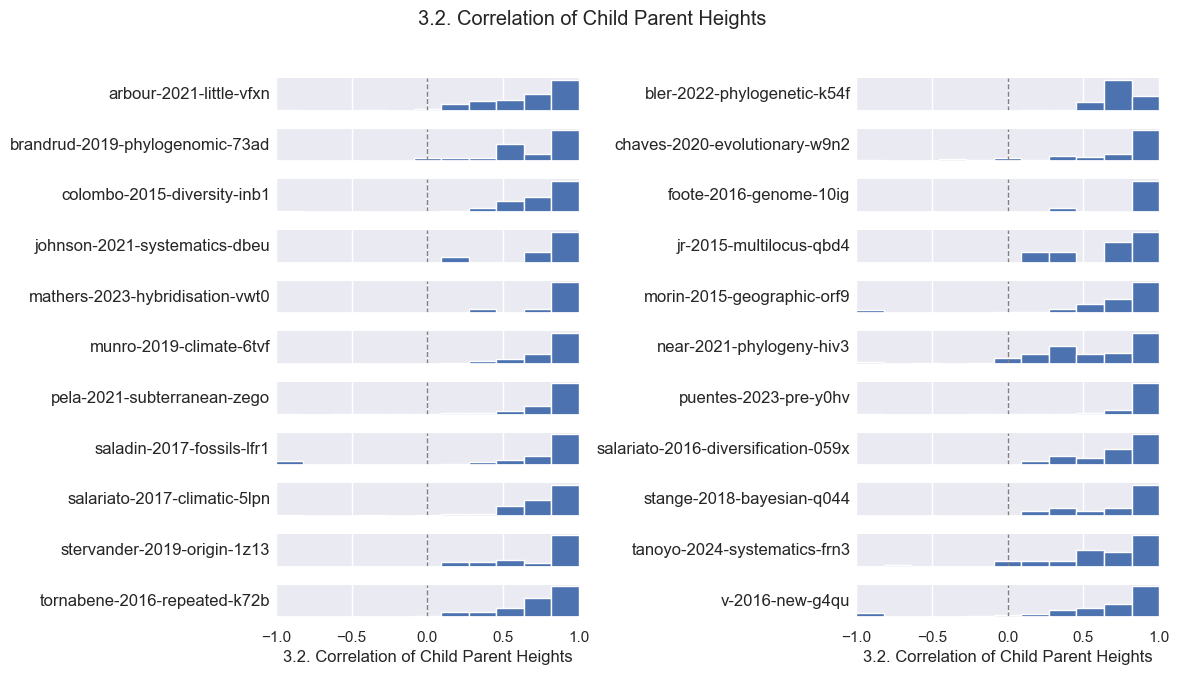

/var/folders/gf/xs1vj06903d3n69s2lv68f6h0000gq/T/ipykernel_89544/4261833978.py:48: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


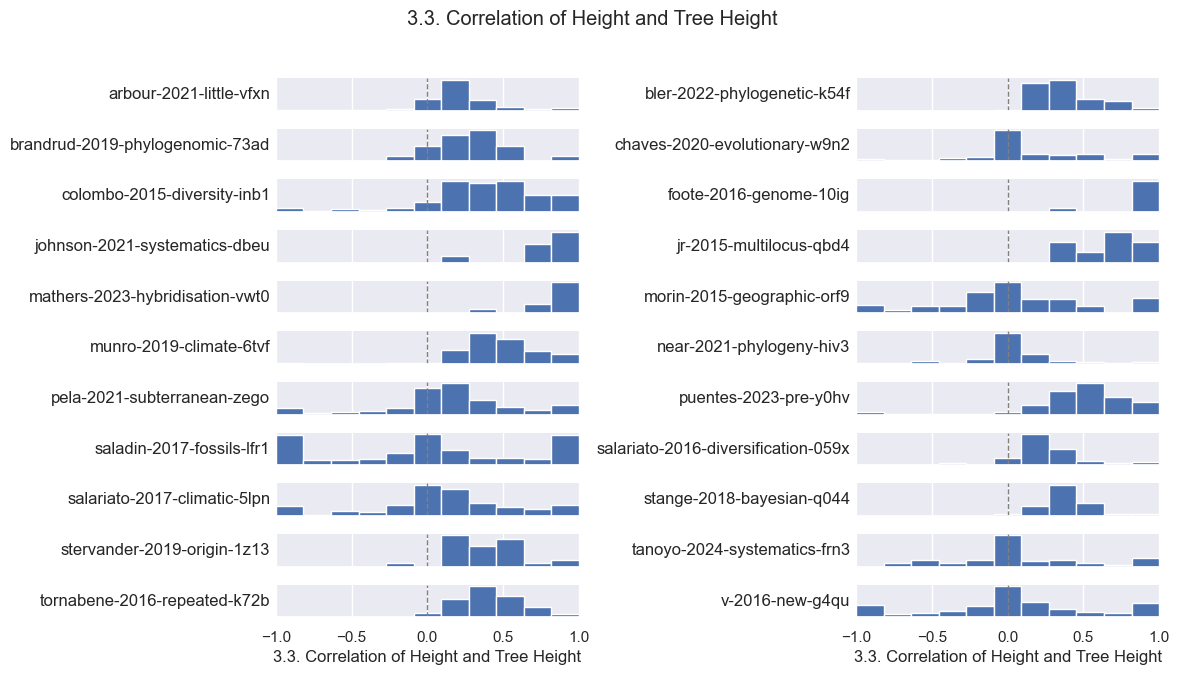

In [47]:
for analysis_name, columns in CORRELATION_ANALYSES.items():
    clade_corrs = []
    for exp_id, group in clade_df.groupby("experiment_id"):
        for clade, clade_group in group.groupby("clade"):
            if clade_group[columns].shape[0] > 1:
                corr = clade_group[columns].corr().iloc[0, 1]
            else:
                corr = np.nan
            clade_corrs.append({
                "experiment_id": exp_id,
                "clade": clade,
                "corr": corr
            })
    clade_corrs_df = pd.DataFrame(clade_corrs)

    experiment_ids = clade_corrs_df["experiment_id"].unique()
    n_experiments = len(experiment_ids)

    # Define two columns for the grid
    ncols = 2
    nrows = int(np.ceil(n_experiments / ncols))

    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(12, nrows * 0.6),
        sharex=True,
        constrained_layout=True
    )

    axes_flat = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    for idx, (ax, exp_id) in enumerate(zip(axes_flat, experiment_ids)):
        data = clade_corrs_df.loc[clade_corrs_df["experiment_id"] == exp_id, "corr"].dropna()
        ax.hist(data, bins=np.linspace(-1, 1, 12))
        ax.axvline(0, color='gray', linestyle='--', linewidth=1)  # Add a line for x=0
        ax.set_ylabel(exp_id, rotation=0, ha='right', va='center')
        ax.set_yticks([])
        ax.set_xlim(-1, 1)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

    # Set x-label only on the bottom plots
    for ax in axes_flat[-ncols:]:
        ax.set_xlabel(analysis_name)

    plt.suptitle(analysis_name, y=1.02)
    plt.tight_layout()
    plt.show()

### Correlation through time

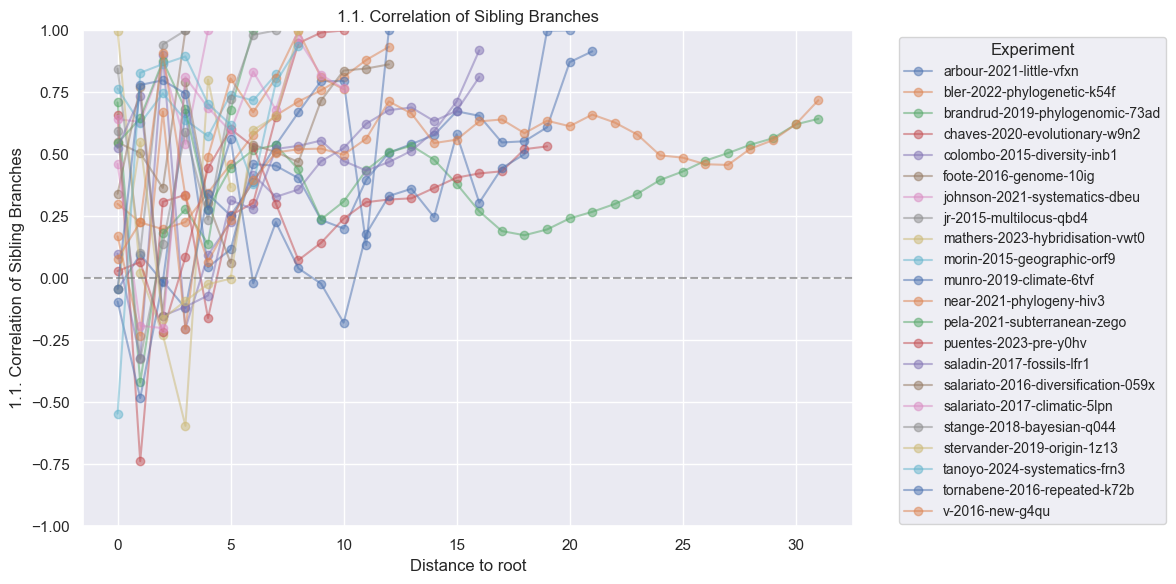

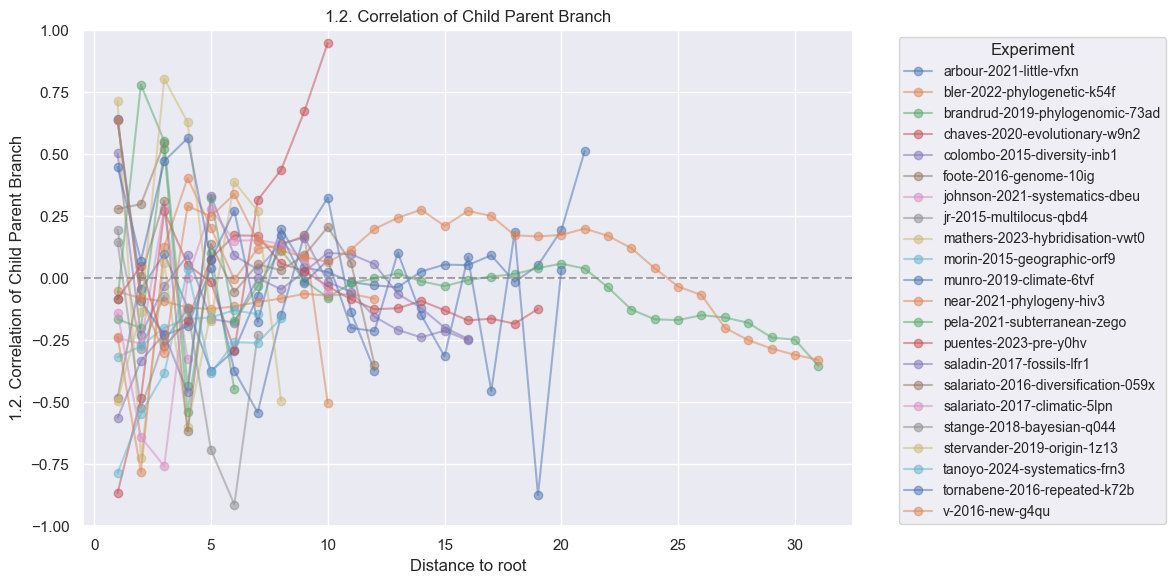

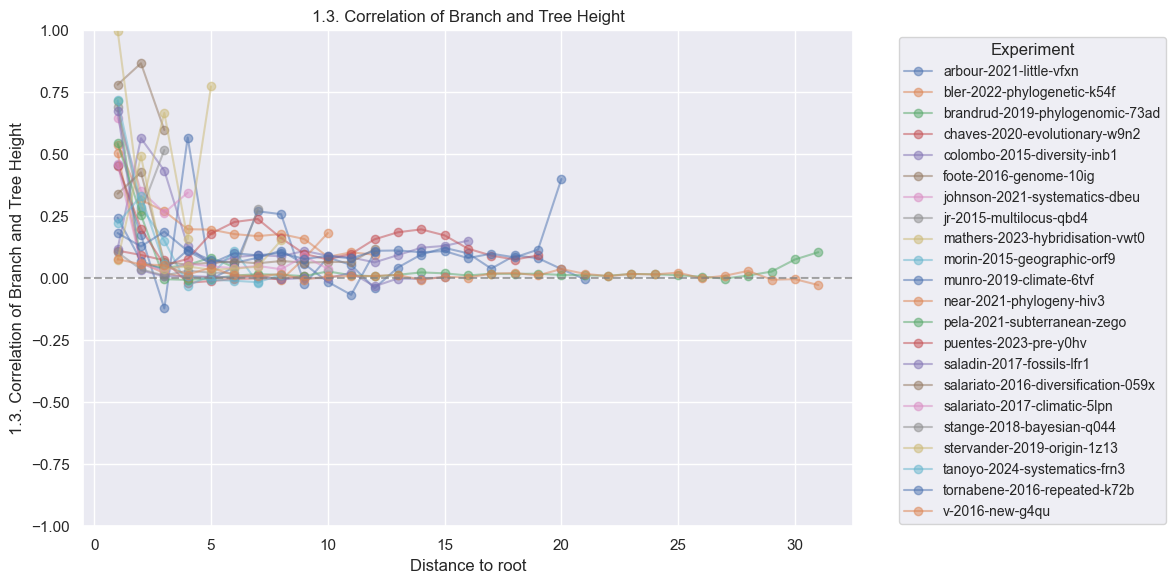

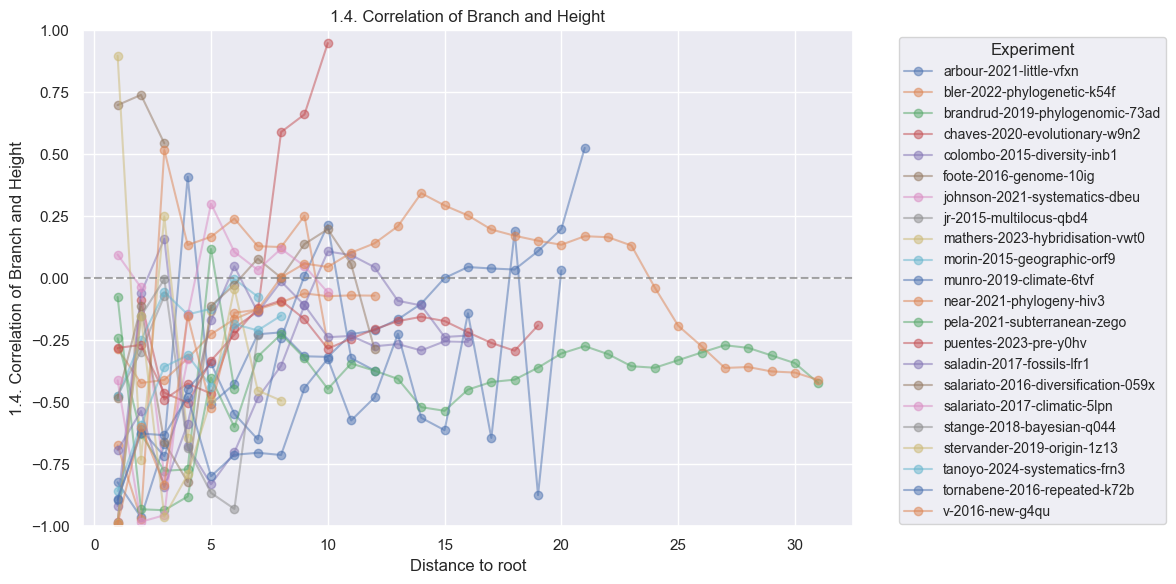

/var/folders/gf/xs1vj06903d3n69s2lv68f6h0000gq/T/ipykernel_89544/1572392818.py:20: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  r, _ = pearsonr(subset[col_1], subset[col_2])


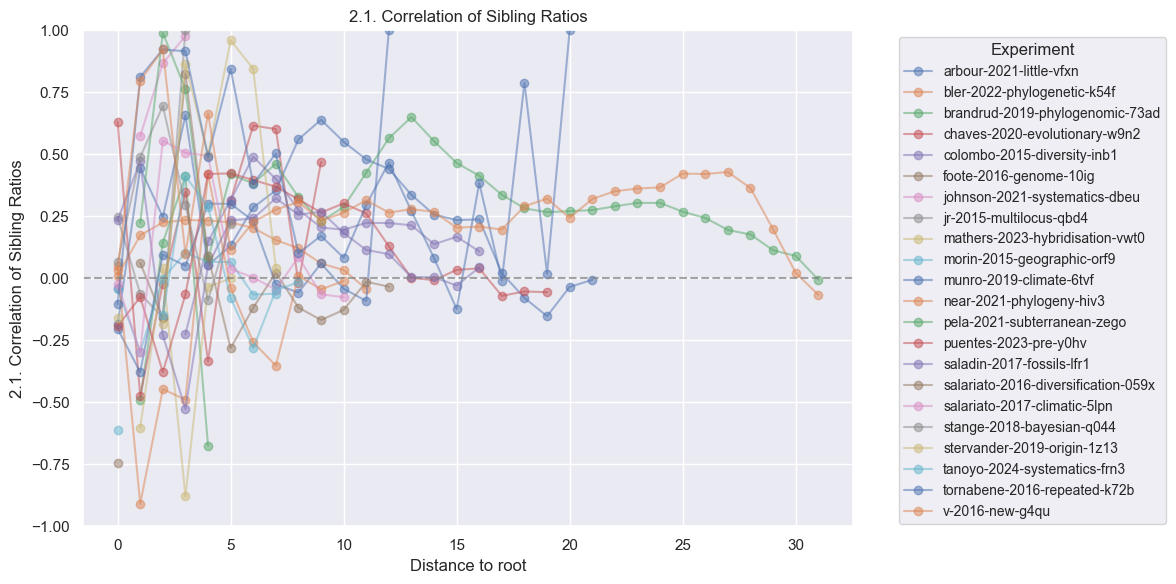

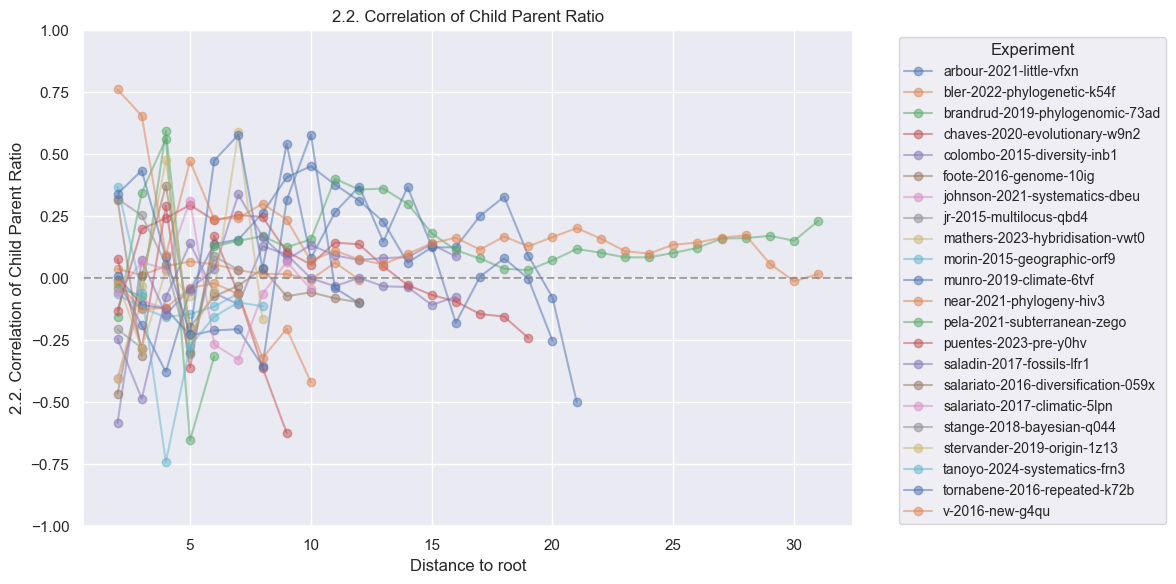

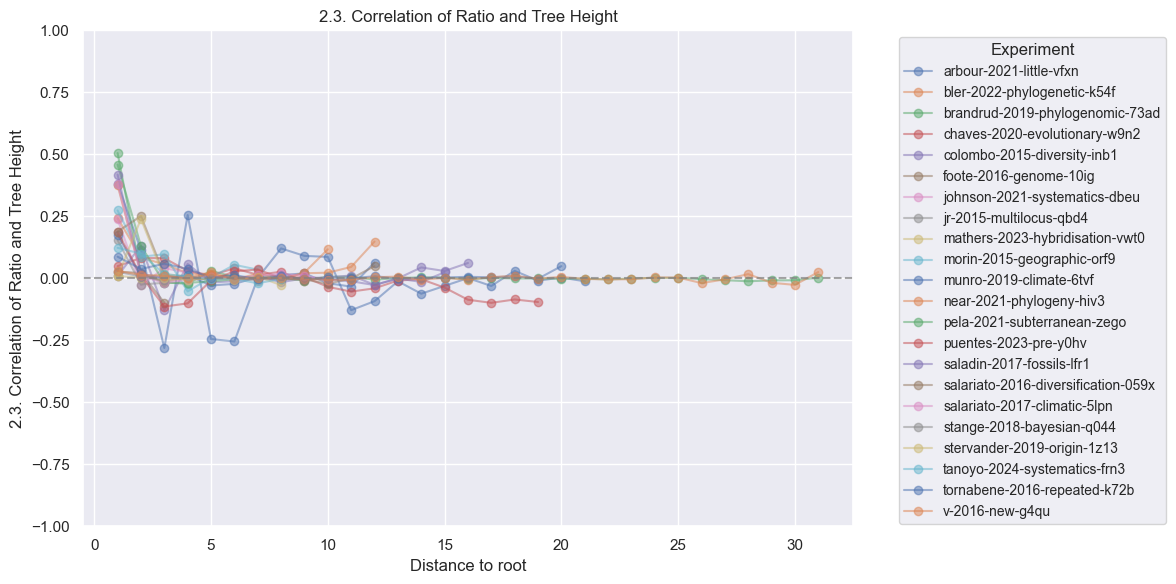

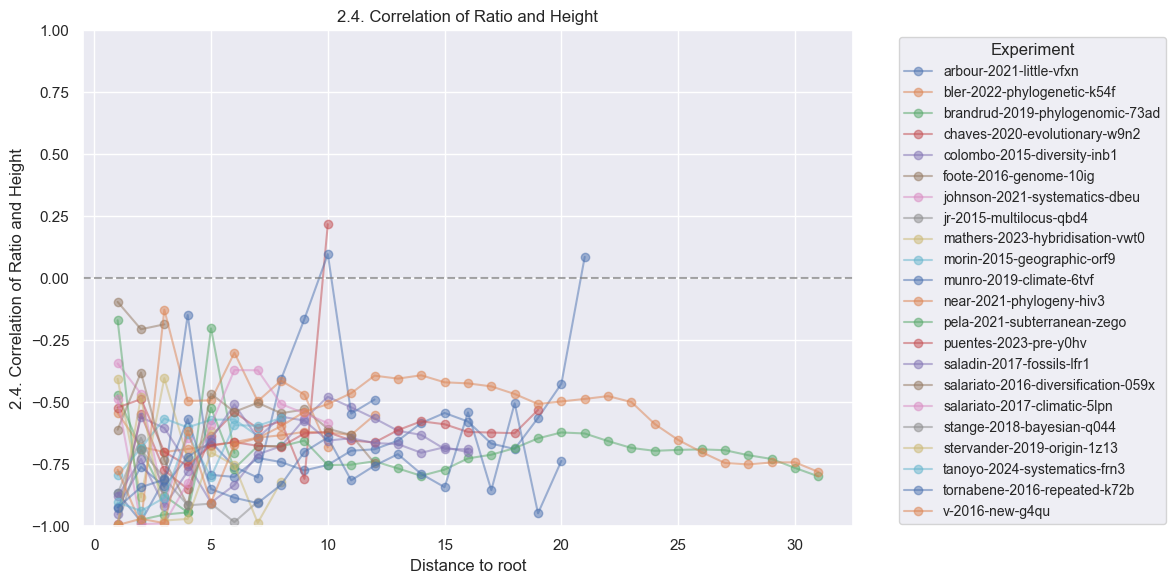

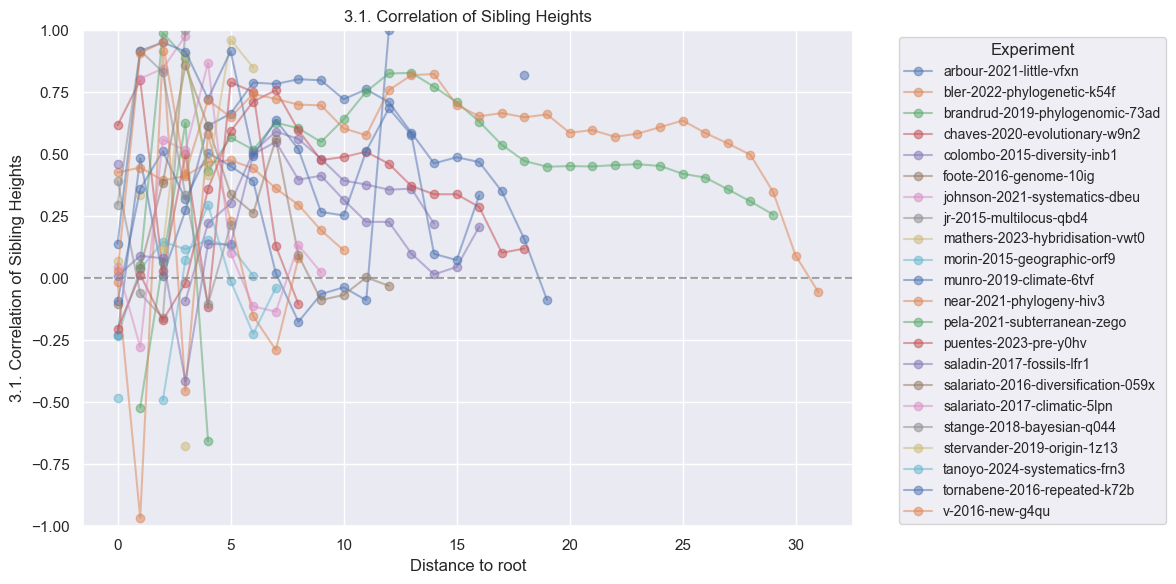

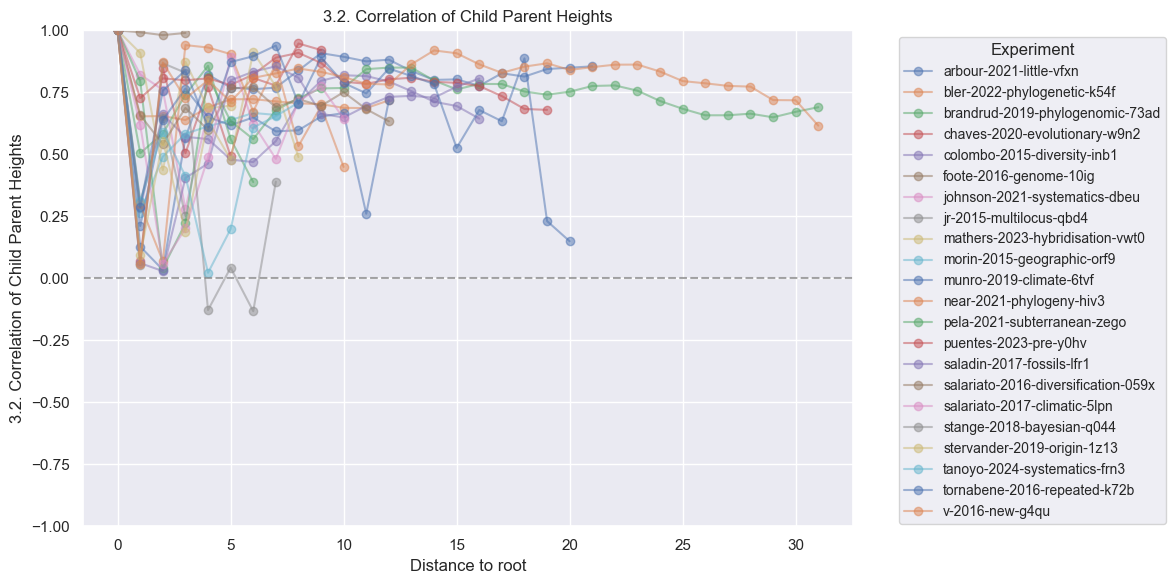

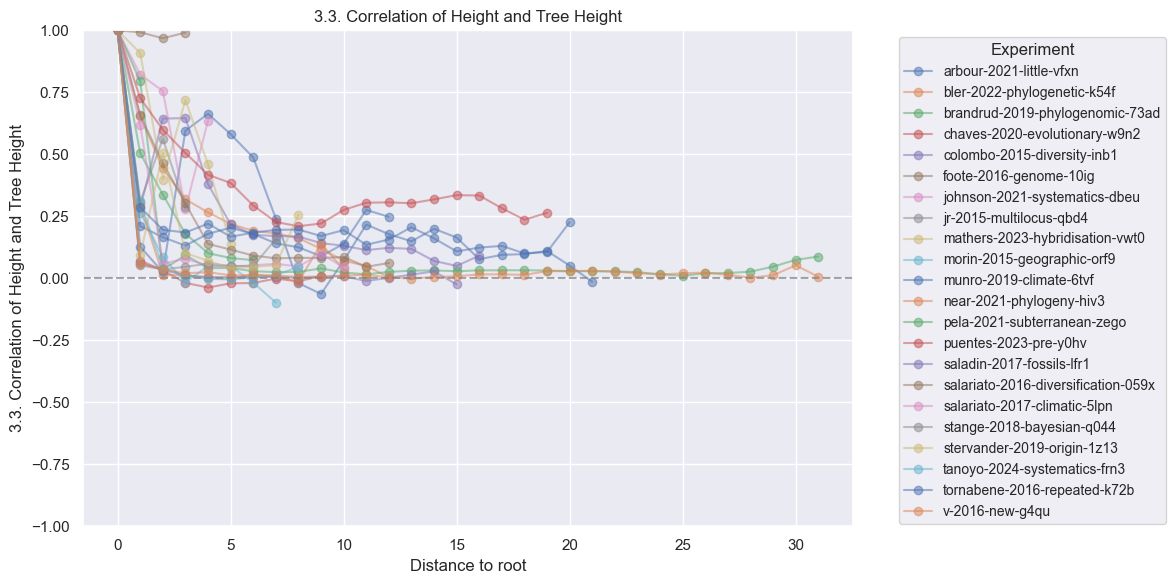

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import numpy as np

MIN_VALUES_CONSIDERED = 100

for analysis_name, (col_1, col_2) in CORRELATION_ANALYSES.items():
    plt.figure(figsize=(12, 6))

    for exp_id, exp_group in clade_df.groupby("experiment_id"):
        distance_vals = np.sort(exp_group["distance_to_root"].unique())
        
        corrs = []
        valid_distances = []
        for dist in distance_vals:
            subset = exp_group[exp_group["distance_to_root"] == dist]
        
            # Only calculate if there are enough values
            if subset[col_1].nunique() > MIN_VALUES_CONSIDERED and subset[col_2].nunique() > MIN_VALUES_CONSIDERED:
                r, _ = pearsonr(subset[col_1], subset[col_2])
                corrs.append(r)
                valid_distances.append(dist)
            else:
                # Not enough data to calculate a correlation
                corrs.append(np.nan)
                valid_distances.append(dist)
        plt.plot(valid_distances, corrs, marker='o', label=exp_id, alpha=0.5)

    plt.xlabel("Distance to root")
    plt.ylabel(analysis_name)
    plt.axhline(0, color='grey', linestyle='--', alpha=0.7)
    plt.ylim(-1, 1)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize="small", title="Experiment")
    plt.title(analysis_name)
    plt.tight_layout()
    plt.show()
